In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


Patient ID and Diagnosis from the Training Dataset:
      patient_id  diagnosis
0              1          0
1              2          0
2              3          0
3              7          0
4              8          0
...          ...        ...
3995        4996          0
3996        4997          0
3997        4998          0
3998        4999          0
3999        5000          0

[4000 rows x 2 columns]


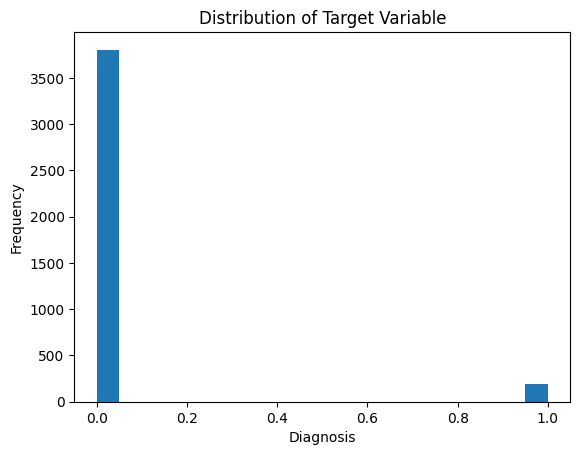

Fitting 3 folds for each of 216 candidates, totalling 648 fits
Best parameters found: {'bootstrap': False, 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
 ROC-AUC Score with Optimized RandomForestClassifier: 0.9776341055714424
Accuracy: 0.9776609724047306
Precision: 0.9813333333333333
Recall: 0.9735449735449735
F1 Score: 0.9774236387782205
Confusion Matrix: 
[[752  14]
 [ 20 736]]

Validation Actual vs Predicted:
      actual  predicted
2644       0          0
2227       0          0
5698       1          1
132        0          0
3172       0          0

Test Predictions:
   patient_id  prediction
0           4           0
1           5           0
2           6           0
3          10           0
4          12           0
File saved successfully at: /content/drive/MyDrive/SE22UCSE187_predictions.csv


In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import os
from imblearn.over_sampling import BorderlineSMOTE

# Load your datasets
train_df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Disease_train.csv")
test_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Disease_test.csv')

# Print all the values of patient_id and diagnosis from the training dataset
print("Patient ID and Diagnosis from the Training Dataset:")
print(train_df[['patient_id', 'diagnosis']])

# Visualize the distribution of the target variable
plt.hist(train_df['diagnosis'], bins=20)
plt.title('Distribution of Target Variable')
plt.xlabel('Diagnosis')
plt.ylabel('Frequency')
plt.show()

# Extract features and target from training data
X = train_df.drop(['patient_id', 'diagnosis'], axis=1)
y = train_df['diagnosis']

# Drop 'patient_id' from test set
X_test = test_df.drop('patient_id', axis=1)

# Standard scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X)
X_test_scaled = scaler.transform(X_test)

# Apply BorderlineSMOTE to handle class imbalance
borderline_smote = BorderlineSMOTE(random_state=42)
X_resampled, y_resampled = borderline_smote.fit_resample(X_train_scaled, y)

# Split the resampled data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Set the parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Initialize the RandomForestClassifier
rf_model = RandomForestClassifier(random_state=42)

# Initialize the GridSearchCV object
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=3, scoring='roc_auc', n_jobs=-1, verbose=2)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Get the best parameters from the grid search
best_params = grid_search.best_params_
print(f"Best parameters found: {best_params}")

# Initialize and train the optimized RandomForestClassifier
optimized_rf_model = RandomForestClassifier(**best_params, random_state=42)
optimized_rf_model.fit(X_train, y_train)

# Evaluate the optimized model on the validation set
y_val_pred = optimized_rf_model.predict(X_val)
roc_auc = roc_auc_score(y_val, y_val_pred)
print(f' ROC-AUC Score with Optimized RandomForestClassifier: {roc_auc}')

# Calculate other metrics
accuracy = accuracy_score(y_val, y_val_pred)
precision = precision_score(y_val, y_val_pred)
recall = recall_score(y_val, y_val_pred)
f1 = f1_score(y_val, y_val_pred)
conf_matrix = confusion_matrix(y_val, y_val_pred)

# Print the metrics
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')
print(f'Confusion Matrix: \n{conf_matrix}')

# Create a DataFrame with actual and predicted values
validation_results = pd.DataFrame({
    'actual': y_val,
    'predicted': y_val_pred
})

# Print the DataFrame
print("\nValidation Actual vs Predicted:")
print(validation_results.head())

# Make predictions on the test dataset
test_predictions = optimized_rf_model.predict(X_test_scaled)

# Create a DataFrame with the predictions
predictions_df = pd.DataFrame({
    'patient_id': test_df['patient_id'],
    'prediction': test_predictions
})

# Print the predictions
print("\nTest Predictions:")
print(predictions_df.head())

# Save the predictions to a CSV file
output_path = '/content/drive/MyDrive/SE22UCSE187_predictions.csv'
predictions_df.to_csv(output_path, index=False)

# Confirm the file is saved
if os.path.exists(output_path):
    print(f"File saved successfully at: {output_path}")
else:
    print("File not found.")

In [ ]:
from google.colab import files

# Download the file
files.download(output_path)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import BorderlineSMOTE
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, make_scorer

# 1. Load and Prepare Data
train_data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Disease_train.csv")
test_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Disease_test.csv')

# Separate features and target
features = train_data.drop(columns=['patient_id', 'diagnosis'])
labels = train_data['diagnosis']

# Standardize features for better model performance
feature_scaler = StandardScaler()
scaled_features = feature_scaler.fit_transform(features)

# Apply Borderline SMOTE for handling class imbalance
oversampler = BorderlineSMOTE(random_state=42, kind="borderline-1")
features_oversampled, labels_oversampled = oversampler.fit_resample(scaled_features, labels)

# Prepare testing data (scaling only, no oversampling)
test_features = test_data.drop(columns=['patient_id'])
test_features_scaled = feature_scaler.transform(test_features)

# 2. Model Selection and Cross-Validation

# Use optimized hyperparameters (obtained from GridSearchCV or similar)
optimized_parameters = {
    'n_estimators': 200,
    'max_depth': 20,
    'min_samples_split': 2,
    'min_samples_leaf': 1,
    'bootstrap': False
}
clf = RandomForestClassifier(**optimized_parameters, random_state=42)

# Define evaluation metrics for cross-validation
scoring_metrics = {
    'Accuracy': make_scorer(accuracy_score),
    'Precision': make_scorer(precision_score),
    'Recall': make_scorer(recall_score),
    'F1 Score': make_scorer(f1_score),
    'ROC-AUC': make_scorer(roc_auc_score)
}

# Perform cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_validate(clf, features_oversampled, labels_oversampled, cv=cv, scoring=scoring_metrics)

# 3. Display Cross-Validation Results
print("\nCross-Validation Results:")
for metric, values in cv_scores.items():
    if metric.startswith('test_'):
        metric_name = metric.replace('test_', '')  # Make the name more readable
        print(f"{metric_name}: {np.mean(values):.4f} ± {np.std(values):.4f}")

# 4. Final Model Training and Prediction
final_model = RandomForestClassifier(**optimized_parameters, random_state=42)
final_model.fit(features_oversampled, labels_oversampled)

# Make predictions on the test set
test_predictions = final_model.predict(test_features_scaled)

# 5. Prepare and Save Results
results_df = pd.DataFrame({'patient_id': test_data['patient_id'], 'prediction': test_predictions})

# Save the predictions to a CSV file
output_filename = 'predictions.csv'
output_path = os.path.join('/content/drive/MyDrive/', output_filename)
results_df.to_csv(output_path, index=False)

print(f"\nPredictions saved to: {output_path}")



Cross-Validation Results:
Accuracy: 0.9482 ± 0.0111
Precision: 0.9287 ± 0.0173
Recall: 0.9713 ± 0.0037
F1 Score: 0.9495 ± 0.0103
ROC-AUC: 0.9482 ± 0.0111

Predictions saved to: /content/drive/MyDrive/SE22UCSE193_predictions.csv
